In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [ ]:
# Load the data (using raw string to avoid escape sequence issues)
csv_path = r"graded_exams.csv"
df = pd.read_csv(csv_path)

# Ensure we don't modify original data
df = df.copy()

# Features (excluding actual grade columns)
features = df.drop(columns=['math grade', 'reading grade', 'writing grade', 'student'])

# Target variables
target_math = df['math grade']
target_reading = df['reading grade']
target_writing = df['writing grade']

In [25]:
# Convert categorical variables to one-hot encoding
features_encoded = pd.get_dummies(features)

In [26]:
# Split data
X_train, X_test, y_train_math, y_test_math, y_train_reading, y_test_reading, y_train_writing, y_test_writing = train_test_split(
    features_encoded, target_math, target_reading, target_writing, test_size=0.3, random_state=42
)

In [27]:
# Encode target variables
label_encoder_math = LabelEncoder()
label_encoder_reading = LabelEncoder()
label_encoder_writing = LabelEncoder()

y_train_math_encoded = label_encoder_math.fit_transform(y_train_math)
y_test_math_encoded = label_encoder_math.transform(y_test_math)

y_train_reading_encoded = label_encoder_reading.fit_transform(y_train_reading)
y_test_reading_encoded = label_encoder_reading.transform(y_test_reading)

y_train_writing_encoded = label_encoder_writing.fit_transform(y_train_writing)
y_test_writing_encoded = label_encoder_writing.transform(y_test_writing)

In [28]:
class CBAApriori:
    def __init__(self, min_support=0.01, min_confidence=0.4, min_lift=1.0, max_rules=100):
        self.min_support = min_support
        self.min_confidence = min_confidence
        self.min_lift = min_lift
        self.max_rules = max_rules
        self.rules = []
        self.default_class = None
        self.class_mapping = {}
        
    def _prepare_data_for_apriori(self, X, y):
        """
        Convert data into a format suitable for Apriori algorithm.
        For continuous features, we discretize them into binary.
        """
        # Create a copy of X
        data = X.copy()
        
        # Add class labels as separate columns (one-hot encoded)
        unique_classes = np.unique(y)
        for cls in unique_classes:
            data[f'class_{cls}'] = (y == cls).astype(int)
            self.class_mapping[f'class_{cls}'] = cls
        
        # For continuous features, convert to binary
        for col in X.columns:
            if data[col].nunique() > 2:
                # For non-binary features, create multiple binary features
                # based on different thresholds (median is a simple choice)
                median = data[col].median()
                data[f'{col}_high'] = (data[col] > median).astype(int)
                data[f'{col}_low'] = (data[col] <= median).astype(int)
                # Remove original column
                data.drop(columns=[col], inplace=True)
        
        # Convert to boolean format as required by Apriori
        return data.astype(bool)
    
    def fit(self, X, y):
        # Set default class (most frequent)
        self.default_class = np.bincount(y).argmax()
        
        # Prepare data for Apriori
        data = self._prepare_data_for_apriori(X, y)
        
        # Generate frequent itemsets
        print("Mining frequent itemsets...")
        frequent_itemsets = apriori(data, min_support=self.min_support, use_colnames=True)
        
        if frequent_itemsets.empty:
            print("No frequent itemsets found. Try lowering min_support.")
            return self
        
        print(f"Found {len(frequent_itemsets)} frequent itemsets.")
        
        # Generate association rules
        print("Generating association rules...")
        all_rules = association_rules(frequent_itemsets, metric="confidence", 
                                     min_threshold=self.min_confidence)
        
        if all_rules.empty:
            print("No rules generated. Try lowering min_confidence.")
            return self
        
        # Apply min lift filter
        all_rules = all_rules[all_rules['lift'] >= self.min_lift]  # Filter by min lift
        if all_rules.empty:
            print("No rules generated. Try lowering min_lift.")
            return self
        
        print(f"Generated {len(all_rules)} association rules.")
        
        # Filter rules where class is in the consequent and no other attributes
        class_rules = []
        for _, rule in all_rules.iterrows():
            antecedents = rule['antecedents']
            consequents = rule['consequents']
            
            # Check if any class label is in the consequent and not in the antecedent
            is_class_rule = False
            class_value = None
            
            for item in consequents:
                if 'class_' in item:
                    is_class_rule = True
                    class_value = self.class_mapping[item]
                    break
            
            # Reject rule if antecedent contains any class labels
            if is_class_rule and not any('class_' in item for item in antecedents):
                # Convert to our rule format
                class_rules.append({
                    'antecedents': antecedents,
                    'class': class_value,
                    'support': rule['support'],
                    'confidence': rule['confidence'],
                    'lift': rule['lift']
                })
        
        # Sort by confidence, then support, then lift
        sorted_rules = sorted(class_rules, 
                             key=lambda x: (x['confidence'], x['support'], x['lift']), 
                             reverse=True)
        
        # Select top N rules
        self.rules = sorted_rules[:self.max_rules]
        print(f"Selected {len(self.rules)} classification rules.")
        
        return self
    
    def predict(self, X):
        """Predict class labels for samples in X."""
        if not self.rules:
            # If no rules were learned, use default class
            return np.full(len(X), self.default_class)
        
        # Prepare test data to match training format
        X_prepared = self._prepare_data_for_apriori(X, np.zeros(len(X)))
        
        # Remove any class columns from test data
        class_cols = [col for col in X_prepared.columns if 'class_' in col]
        X_prepared = X_prepared.drop(columns=class_cols)
        
        predictions = np.full(len(X), self.default_class)
        matched = np.zeros(len(X), dtype=bool)
        
        # Apply rules in order
        for rule in self.rules:
            antecedents = rule['antecedents']
            
            # Find instances that match all antecedents and haven't been classified yet
            for i, row in enumerate(X_prepared.itertuples(index=False)):
                if matched[i]:
                    continue  # Skip already matched instances
                
                # Check if all antecedents are true for this instance
                row_dict = {X_prepared.columns[idx]: val for idx, val in enumerate(row)}
                if all(row_dict.get(attr, False) for attr in antecedents):
                    predictions[i] = rule['class']
                    matched[i] = True
        
        return predictions
    
    def explain_rules(self, class_names=None, top_n=10):
        if not self.rules:
            print("No rules available.")
            return
        
        print(f"\nTop {min(top_n, len(self.rules))} Rules:")
        
        for i, rule in enumerate(self.rules[:top_n]):
            antecedents_str = " AND ".join(sorted(rule['antecedents']))
            
            # Use class names if provided
            if class_names is not None:
                class_str = class_names[rule['class']]
            else:
                class_str = rule['class']
                
            print(f"Rule {i+1}: IF {antecedents_str} THEN class = {class_str}")
            print(f"   Support: {rule['support']:.4f}, Confidence: {rule['confidence']:.4f}, Lift: {rule['lift']:.4f}")
            
        if class_names is not None:
            print(f"\nDefault class: {class_names[self.default_class]}")
        else:
            print(f"\nDefault class: {self.default_class}")

In [29]:
# Train CBA models with updated min_lift
print("Training Math CBA model...")
math_model = CBAApriori(min_support=0.02, min_confidence=0.6, min_lift=1.2)  # Added min_lift
math_model.fit(X_train, y_train_math_encoded)

print("Training Reading CBA model...")
reading_model = CBAApriori(min_support=0.02, min_confidence=0.6, min_lift=1.2)  # Added min_lift
reading_model.fit(X_train, y_train_reading_encoded)

print("Training Writing CBA model...")
writing_model = CBAApriori(min_support=0.02, min_confidence=0.6, min_lift=1.2)  # Added min_lift
writing_model.fit(X_train, y_train_writing_encoded)

Training Math CBA model...
Mining frequent itemsets...
Found 9944 frequent itemsets.
Generating association rules...
Generated 35272 association rules.
Selected 100 classification rules.
Training Reading CBA model...
Mining frequent itemsets...
Found 9883 frequent itemsets.
Generating association rules...
Generated 37866 association rules.
Selected 100 classification rules.
Training Writing CBA model...
Mining frequent itemsets...
Found 9947 frequent itemsets.
Generating association rules...
Generated 37620 association rules.
Selected 100 classification rules.


In [30]:
# Make predictions
y_pred_math = math_model.predict(X_test)
y_pred_reading = reading_model.predict(X_test)
y_pred_writing = writing_model.predict(X_test)

In [31]:
# Evaluate predictions
def evaluate_classifier(y_true, y_pred, class_names, subject):
    print(f"\n=== {subject} Evaluation ===")
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
    print(report)
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{subject} Confusion Matrix")
    plt.tight_layout()
    plt.show()


=== Math Evaluation ===
Accuracy: 0.6067
               precision    recall  f1-score   support

Above Average       0.00      0.00      0.00         9
      Average       0.00      0.00      0.00        24
Below Average       0.00      0.00      0.00        29
    Excellent       0.00      0.00      0.00        10
      Failure       0.61      1.00      0.76       182
         Good       0.00      0.00      0.00        11
      Passing       0.00      0.00      0.00        28
     Superior       0.00      0.00      0.00         7

     accuracy                           0.61       300
    macro avg       0.08      0.12      0.09       300
 weighted avg       0.37      0.61      0.46       300



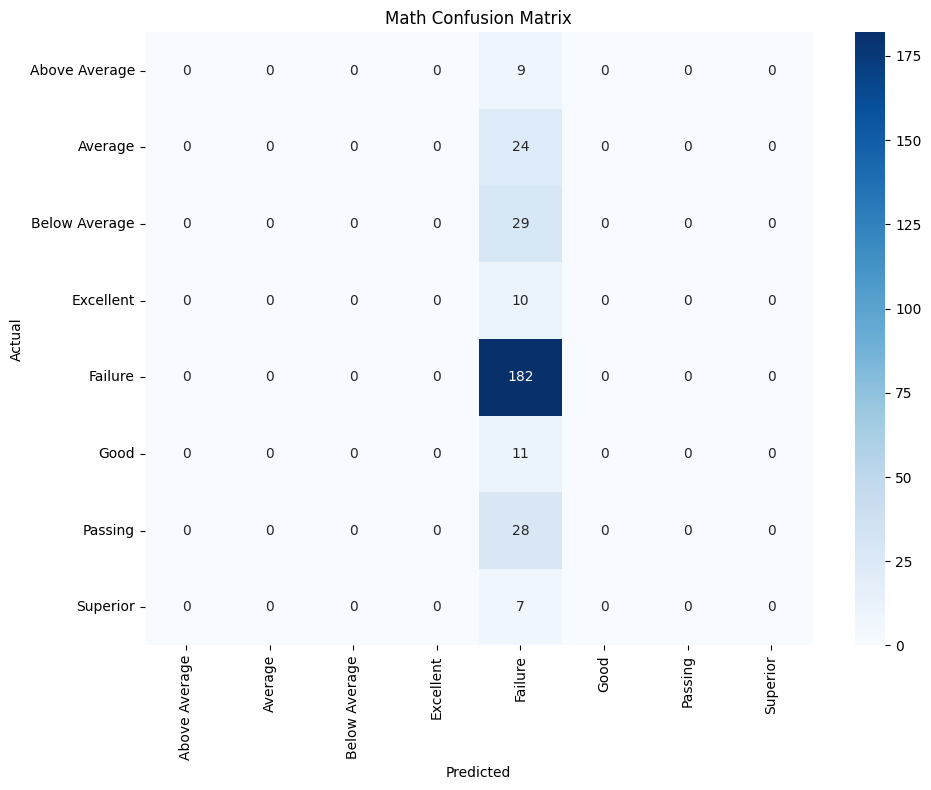


=== Reading Evaluation ===
Accuracy: 0.5533
               precision    recall  f1-score   support

Above Average       0.00      0.00      0.00        23
      Average       0.00      0.00      0.00        27
Below Average       0.00      0.00      0.00        25
    Excellent       0.00      0.00      0.00         8
      Failure       0.55      1.00      0.71       166
         Good       0.00      0.00      0.00        12
      Passing       0.00      0.00      0.00        32
     Superior       0.00      0.00      0.00         7

     accuracy                           0.55       300
    macro avg       0.07      0.12      0.09       300
 weighted avg       0.31      0.55      0.39       300



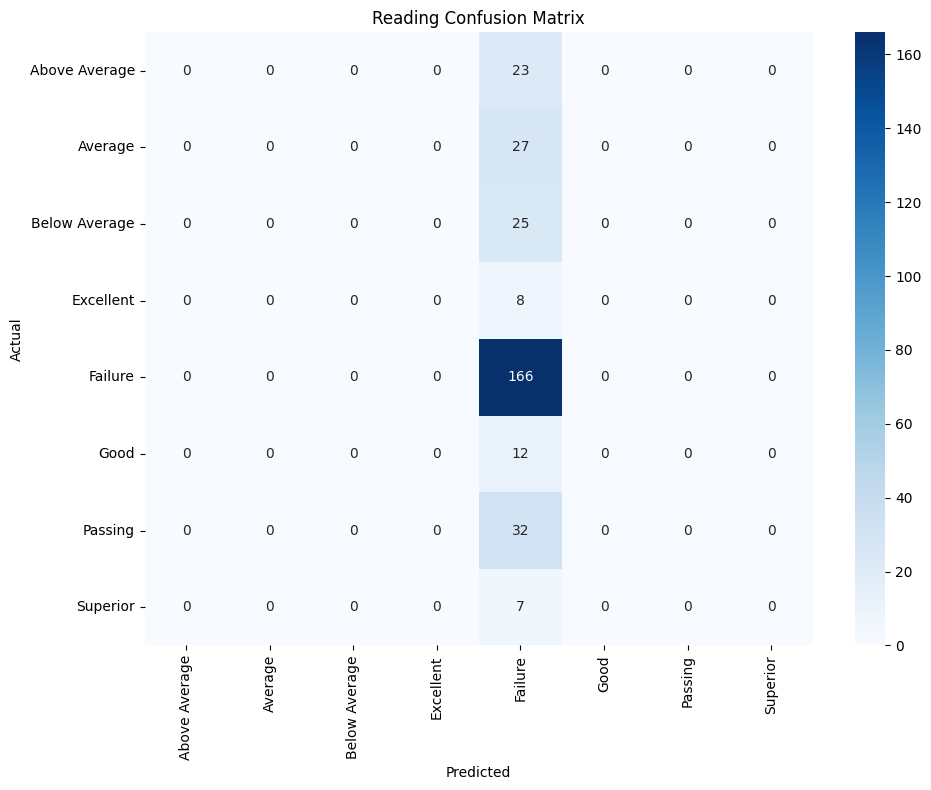


=== Writing Evaluation ===
Accuracy: 0.6033
               precision    recall  f1-score   support

Above Average       0.00      0.00      0.00        18
      Average       0.00      0.00      0.00        18
Below Average       0.00      0.00      0.00        29
    Excellent       0.00      0.00      0.00        11
      Failure       0.60      1.00      0.75       181
         Good       0.00      0.00      0.00        13
      Passing       0.00      0.00      0.00        23
     Superior       0.00      0.00      0.00         7

     accuracy                           0.60       300
    macro avg       0.08      0.12      0.09       300
 weighted avg       0.36      0.60      0.45       300



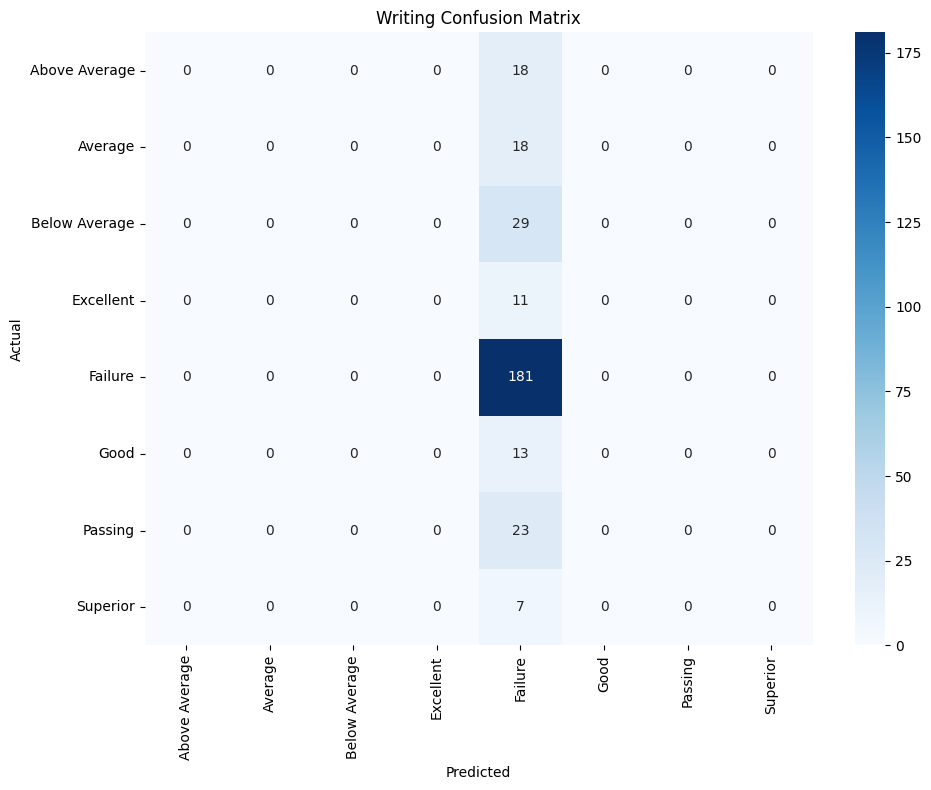

In [32]:
# Get class names
math_classes = label_encoder_math.classes_
reading_classes = label_encoder_reading.classes_
writing_classes = label_encoder_writing.classes_

# Evaluate models
evaluate_classifier(y_test_math_encoded, y_pred_math, math_classes, "Math")
evaluate_classifier(y_test_reading_encoded, y_pred_reading, reading_classes, "Reading")
evaluate_classifier(y_test_writing_encoded, y_pred_writing, writing_classes, "Writing")

In [33]:
# Explain the rules
print("\n=== Math Rules ===")
math_model.explain_rules(class_names=math_classes)

print("\n=== Reading Rules ===")
reading_model.explain_rules(class_names=reading_classes)

print("\n=== Writing Rules ===")
writing_model.explain_rules(class_names=writing_classes)


=== Math Rules ===

Top 10 Rules:
Rule 1: IF math score_low THEN class = Failure
   Support: 0.5021, Confidence: 1.0000, Lift: 1.5923
Rule 2: IF math score_low AND reading score_low THEN class = Failure
   Support: 0.4163, Confidence: 1.0000, Lift: 1.5923
Rule 3: IF math score_low AND writing score_low THEN class = Failure
   Support: 0.4006, Confidence: 1.0000, Lift: 1.5923
Rule 4: IF math score_low AND reading score_low AND writing score_low THEN class = Failure
   Support: 0.3805, Confidence: 1.0000, Lift: 1.5923
Rule 5: IF math score_low AND test preparation course_none THEN class = Failure
   Support: 0.3634, Confidence: 1.0000, Lift: 1.5923
Rule 6: IF math score_low AND reading score_low AND test preparation course_none THEN class = Failure
   Support: 0.3104, Confidence: 1.0000, Lift: 1.5923
Rule 7: IF math score_low AND test preparation course_none AND writing score_low THEN class = Failure
   Support: 0.3062, Confidence: 1.0000, Lift: 1.5923
Rule 8: IF math score_low AND read